### Importing necessary libraries and files

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [2]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


### Preprocessing

In [3]:
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


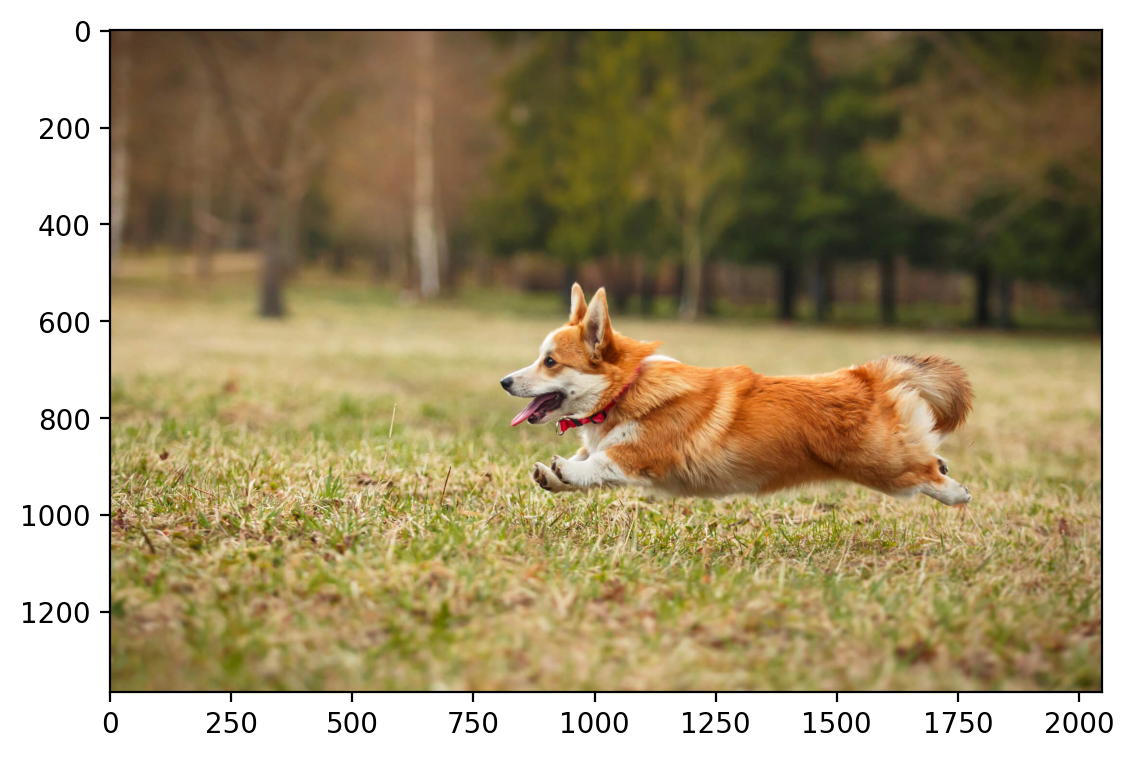

In [4]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())


In [5]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [6]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [7]:
img_scaled = img_scaled.to(device)

In [8]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 670, 830, 150, 150)
crop.shape

torch.Size([3, 150, 150])

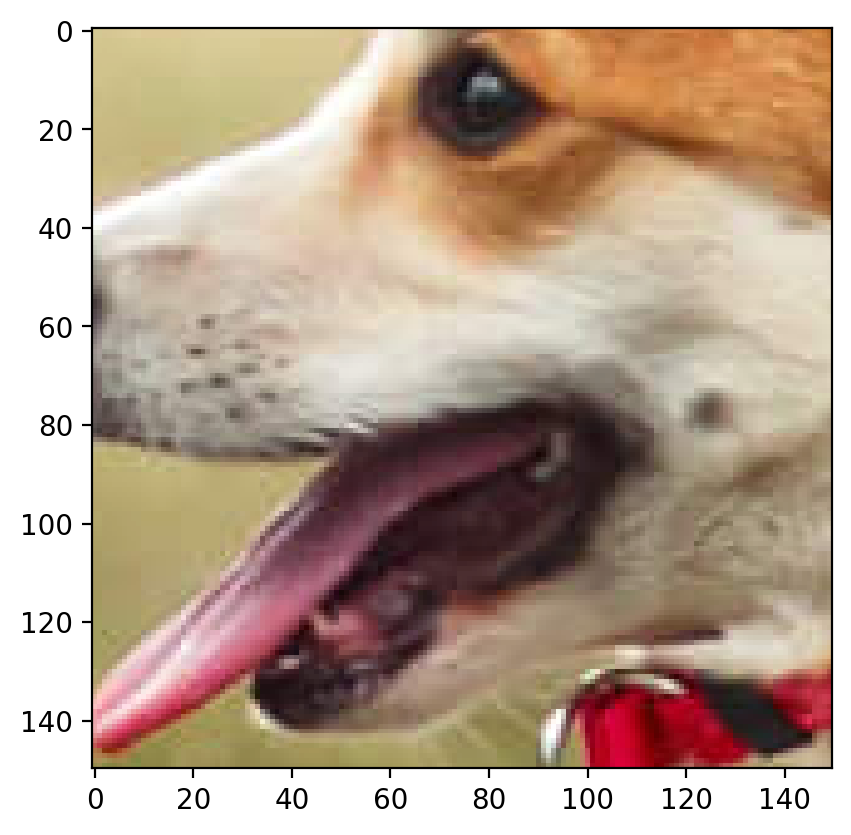

In [9]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())


In [10]:
crop = crop.to(device)


In [11]:
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 150 150


### Linear Model

In [12]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
    def forward(self, x):
        return self.linear(x)

In [13]:
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

### Creating coordinate map

In [14]:

def create_coordinate_map(img):
    num_channels, height, width = img.shape
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)
    X = torch.stack([h_coords, w_coords], dim=1).float()
    X = X.to(device)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y
dog_X, dog_Y = create_coordinate_map(crop)
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())
dog_X_scaled = scaler_X.transform(dog_X.cpu())
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)
dog_X_scaled = dog_X_scaled.float()

In [15]:
def train(net, lr, X, Y, epochs, verbose=True):

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

### RFF Function creation

f_no => number of RFF 


In [16]:
f_no = 20000
sigma = 0.03

In [17]:
def create_rff_features(X, num_features, sigma, random_seed=190):
    from sklearn.kernel_approximation import RBFSampler
    import numpy as np

    np.random.seed(random_seed)

    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2), random_state=random_seed)

    X = X.cpu().numpy()
    X_rff = rff.fit_transform(X)

    return torch.tensor(X_rff, dtype=torch.float32).to(device)
X_rff = create_rff_features(dog_X_scaled, f_no, sigma)

### Model Training

In [18]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff, dog_Y, 200)

Epoch 0 loss: 0.367919
Epoch 100 loss: 0.008380


0.0008741323836147785

### Prediction

Following function takes superresolution factor as parameter and outputs the predicted image

In [19]:
def PredPlot(coor_scale, orig_img, net):
    chann,height,width = orig_img.shape
    coords = np.array([[i/coor_scale, j/coor_scale] for i in range(width*coor_scale) for j in range(width*coor_scale)])
    Xten = torch.tensor(coords)
    scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(Xten.cpu())
    Xten_scaled = scaler_X.transform(Xten.cpu())
    Xten_scaled = torch.tensor(Xten_scaled).to(device)
    Xten_scaled = Xten_scaled.float()
    X = create_rff_features(Xten_scaled, f_no, sigma)
    num_channels, height, width = orig_img.shape
    height*=coor_scale; width*=coor_scale
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")
    ax1.imshow(orig_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    for a in [ax0, ax1]:
        a.axis("off")
    fig.suptitle("", y=0.9)
    plt.tight_layout()
    
    
    return outputs.cpu()

### Predicting on the origina size

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


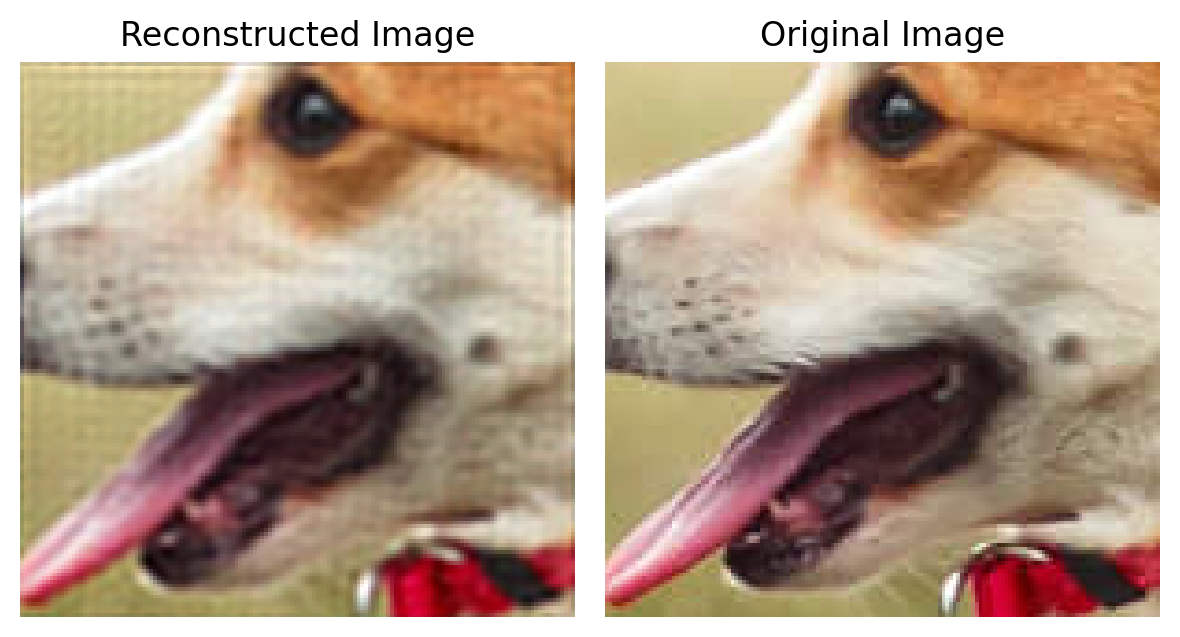

In [20]:
fimg  = PredPlot(1,crop,net) # superresolution factor, image name, model name

### Predicting the image after superresolution

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


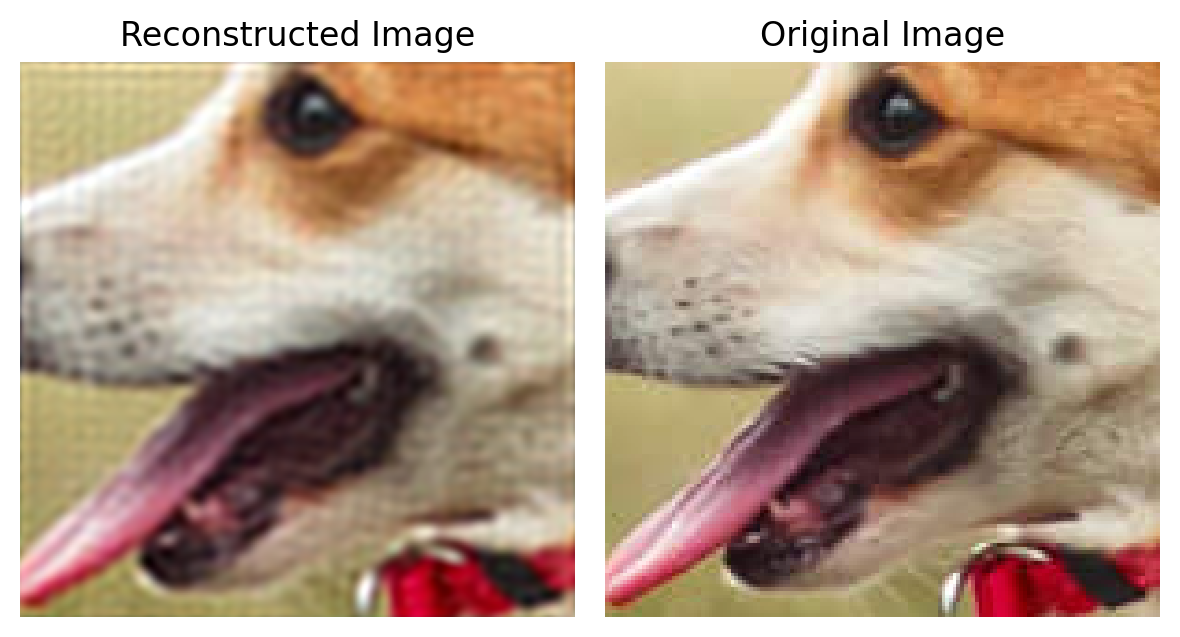

In [21]:
superresolved_img  = PredPlot(2,crop,net)

In [22]:
print(crop.shape)
print(fimg.shape)
print(superresolved_img.shape)

torch.Size([3, 150, 150])
torch.Size([150, 150, 3])
torch.Size([300, 300, 3])


### Hyperparameter tuning

Epoch 0 loss: 0.366796
Epoch 100 loss: 0.050449


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


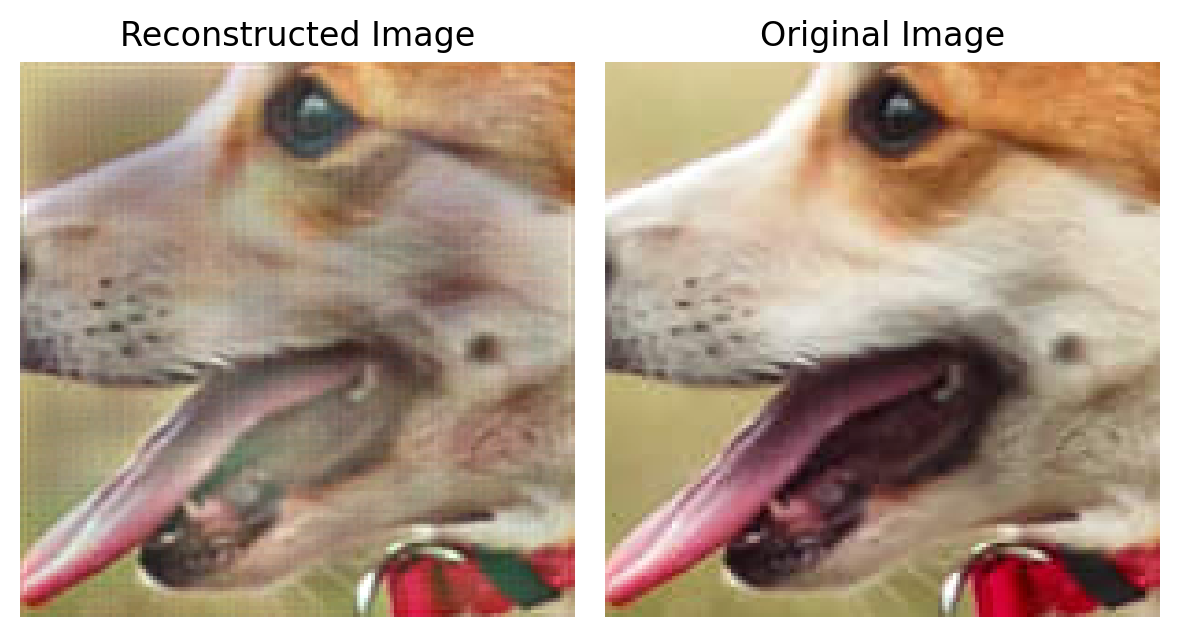

In [23]:
sigma = 0.01
X_rff1 = create_rff_features(dog_X_scaled, f_no, sigma)
net = LinearModel(X_rff.shape[1], 3)
net.to(device)
train(net, 0.005, X_rff1, dog_Y, 200)
fimg  = PredPlot(1,crop,net)

Epoch 0 loss: 0.367112
Epoch 100 loss: 0.023606


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


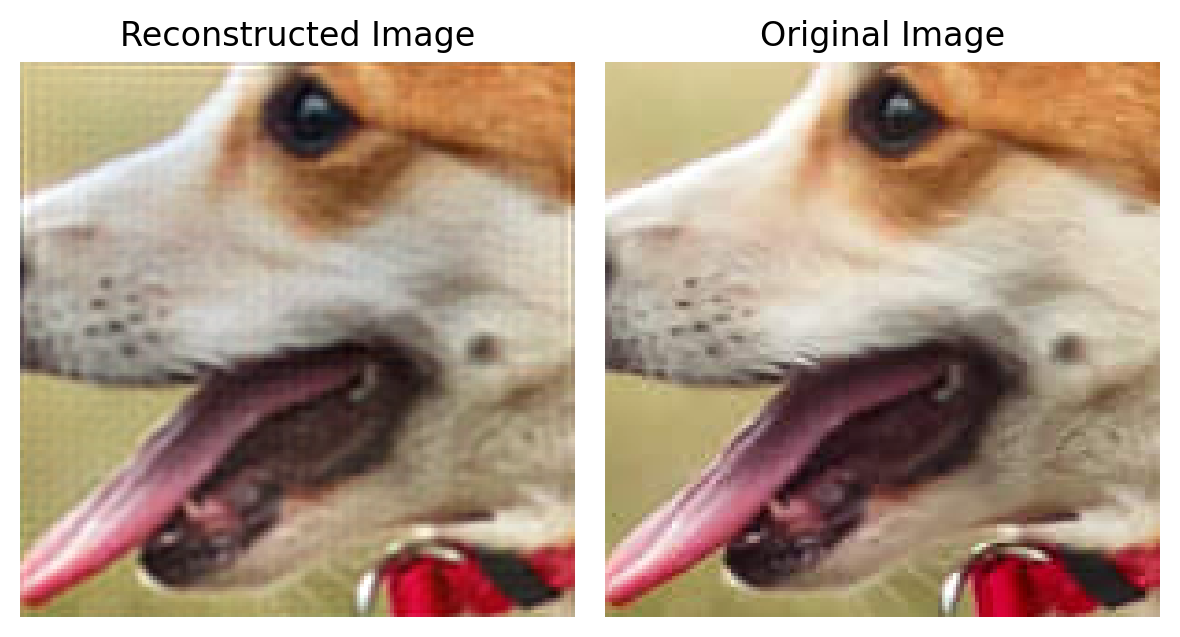

In [24]:
sigma = 0.02
X_rff1 = create_rff_features(dog_X_scaled, f_no, sigma)
net = LinearModel(X_rff.shape[1], 3)
net.to(device)
train(net, 0.005, X_rff1, dog_Y, 200)
fimg  = PredPlot(1,crop,net)

Epoch 0 loss: 0.365632
Epoch 100 loss: 0.008356


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


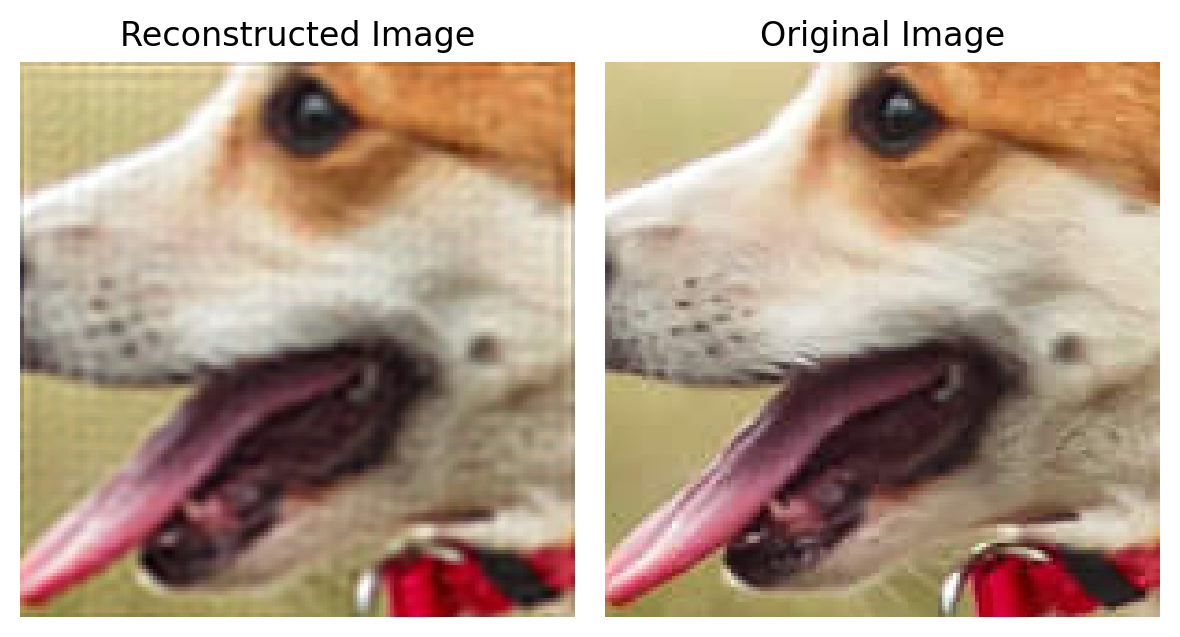

In [25]:
sigma = 0.03
X_rff1 = create_rff_features(dog_X_scaled, f_no, sigma)
net = LinearModel(X_rff.shape[1], 3)
net.to(device)
train(net, 0.005, X_rff1, dog_Y, 200)
fimg  = PredPlot(1,crop,net)

Epoch 0 loss: 0.368613
Epoch 100 loss: 0.002802


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


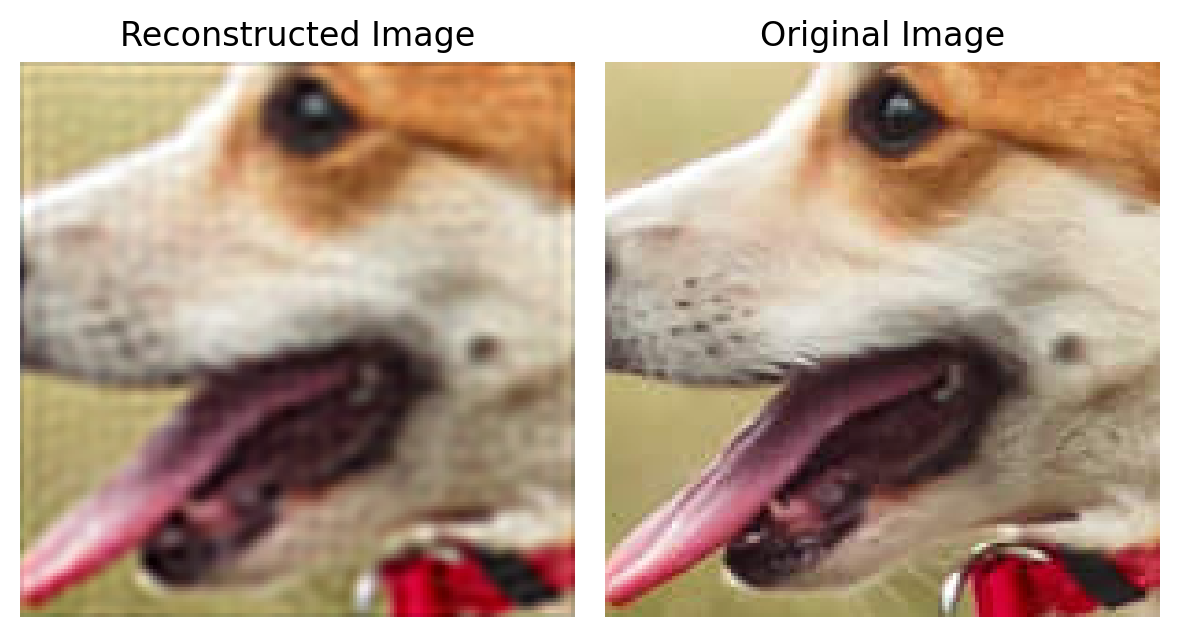

In [26]:
sigma = 0.04
X_rff1 = create_rff_features(dog_X_scaled, f_no, sigma)
net = LinearModel(X_rff.shape[1], 3)
net.to(device)
train(net, 0.005, X_rff1, dog_Y, 200)
fimg  = PredPlot(1,crop,net)

Epoch 0 loss: 0.365833
Epoch 100 loss: 0.002079


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


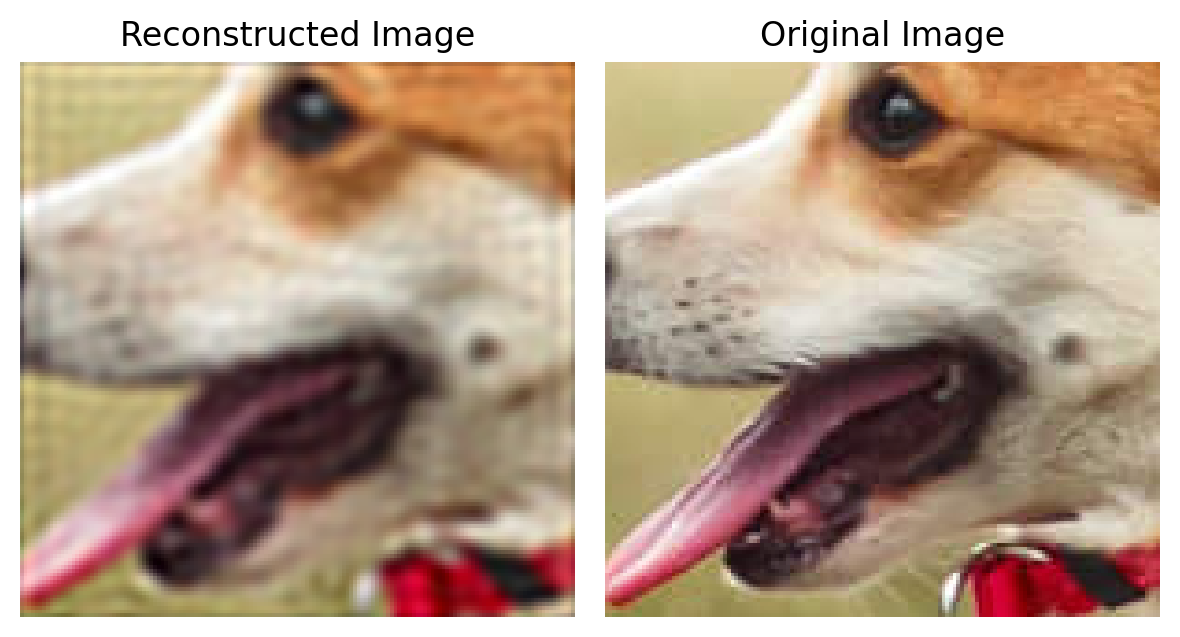

In [27]:
sigma = 0.05
X_rff1 = create_rff_features(dog_X_scaled, f_no, sigma)
net = LinearModel(X_rff.shape[1], 3)
net.to(device)
train(net, 0.005, X_rff1, dog_Y, 200)
fimg  = PredPlot(1,crop,net)